In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import plotly.express as px
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score

from sklearn.cluster import KMeans
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)


In [2]:
# Loading the dataset
campaign_data = pd.read_csv("campaign_data.csv")
# Exploring the dataset
# Set the display options to show all columns
pd.options.display.max_columns = None
print("Type:", type(campaign_data))
print("Dataframe shape is:", campaign_data.shape)
campaign_data.head()

Type: <class 'pandas.core.frame.DataFrame'>
Dataframe shape is: (2240, 27)


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1965  Graduation         Single  58138.0        0         0   
1  2174        1962  Graduation         Single  46344.0        1         1   
2  4141        1973  Graduation       Together  71613.0        0         0   
3  6182        1992  Graduation       Together  26646.0        1         0   
4  5324        1989         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2020       58       635         88              546              172   
1  08-03-2022       38        11          1                6                2   
2  21-08-2021       26       426         49              127              111   
3  10-02-2022       26        11          4               20               10   
4  19-01-2022       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
0             0             0             0             0         0         1  
1             0             0             0             0         0         0  
2             0             0             0             0         0         0  
3             0             0             0             0         0         0  
4             0             0             0             0         0         0

In [3]:
# Check information about the data
campaign_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
# To remove the NA values
campaign_data = campaign_data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(campaign_data))

The total number of data-points after removing the rows with missing values are: 2216


In [5]:
# Formatting date
campaign_data["Dt_Customer"] = pd.to_datetime(campaign_data["Dt_Customer"], format="%d-%m-%Y")

# Verify if work was completed correctly
campaign_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i

In [6]:
# Calculate the age of each customer
campaign_data['Age'] = 2022 - campaign_data['Year_Birth']


# Define age groups
def age_group(age):
    if 18 <= age <= 24:
        return 'Young Adults'
    elif 25 <= age <= 34:
        return 'Early Adulthood'
    elif 35 <= age <= 44:
        return 'Midlife'
    elif 45 <= age <= 54:
        return 'Middle Age'
    elif 55 <= age <= 64:
        return 'Pre-retirement'
    else:
        return 'Retirement Age'

# Create a new 'Age_Range' feature.
campaign_data['Age_Range'] = campaign_data['Age'].apply(age_group)

In [7]:
# Customer tenure
dt_customer = campaign_data['Dt_Customer']
dataset_date = datetime(2022, 12, 31)

# Calculate the customer tenure for each customer
customer_tenure = dataset_date - dt_customer

# Convert the customer tenure to days
campaign_data['Customer_For'] = customer_tenure / np.timedelta64(1, 'D')

# Calculate WebConversionRate
campaign_data['WebConversionRate'] = np.where(campaign_data['NumWebVisitsMonth'] != 0,
                                              campaign_data['NumWebPurchases'] / campaign_data['NumWebVisitsMonth'], 0)
# Calculate the total spent for each customer
campaign_data['Total_Spent'] = campaign_data['MntWines'] + campaign_data['MntFruits'] + campaign_data[
    'MntMeatProducts'] + campaign_data['MntFishProducts'] + campaign_data['MntSweetProducts'] + campaign_data[
                                   'MntGoldProds']

# Calculate total number of purchases
campaign_data['Total_Purchases'] = campaign_data['NumWebPurchases'] + campaign_data['NumCatalogPurchases'] + \
                                   campaign_data['NumStorePurchases']

# Explore the Marital_Status feature
print("Total categories in the feature Marital_Status:\n", campaign_data["Marital_Status"].value_counts(), "\n")

# Deriving number of adults in household by marital status
campaign_data["Adults"] = campaign_data["Marital_Status"].replace(
    {"Married": 2, "Together": 2, "Single": 1, "Divorced": 1, "Widow": 1, "Alone": 1, "Absurd": 1, "YOLO": 1})

# Feature indicating total dependents living in the household
campaign_data["Dependents"] = campaign_data["Kidhome"] + campaign_data["Teenhome"]

# Now you can calculate Household size
campaign_data["Household_size"] = campaign_data["Adults"] + campaign_data["Dependents"]

# Feature pertaining parenthood
campaign_data["Is_Parent"] = np.where(campaign_data.Dependents > 0, 1, 0)

# Calculate the average income for each education category
avg_income_by_education = campaign_data.groupby('Education')['Income'].mean()
# Print the result
print(avg_income_by_education)

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Education
2n Cycle      47633.190000
Basic         20306.259259
Graduation    52720.373656
Master        52917.534247
PhD           56145.313929
Name: Income, dtype: float64


In [8]:
#Calculate the average spent for each education category
avg_spent_by_education = campaign_data.groupby('Education')['Total_Spent'].mean()
# Print the result
print(avg_spent_by_education)

# Updating category
campaign_data["Education"] = campaign_data["Education"].replace(
    {"Graduation": "Postgraduate", "Master": "Postgraduate"})

campaign_data["Offers_Accepted"] = campaign_data["AcceptedCmp1"] + campaign_data["AcceptedCmp2"] + campaign_data[
    "AcceptedCmp3"] + campaign_data["AcceptedCmp4"] + campaign_data["AcceptedCmp5"] + campaign_data["Response"]

# Use the function to_drop to get rid of them.
to_drop = ["Marital_Status", "Dt_Customer", "Year_Birth", "ID", "Kidhome", "Teenhome"]
campaign_data = campaign_data.drop(to_drop, axis=1)

Education
2n Cycle      494.930000
Basic          81.796296
Graduation    621.686380
Master        609.767123
PhD           676.733888
Name: Total_Spent, dtype: float64


In [9]:
# Rename features for clarity
campaign_data = campaign_data.rename(
    columns={"MntWines": "Wine", "MntFruits": "Fruits", "MntMeatProducts": "Meat", "MntFishProducts": "Fish",
             "MntSweetProducts": "Sweets",
             "MntGoldProds": "Gold", "AcceptedCmp1": "Promo1", "AcceptedCmp2": "Promo2", "AcceptedCmp3": "Promo3",
             "AcceptedCmp4": "Promo4", "AcceptedCmp5": "Promo5", "Response": "Promo6", "NumCatalogPurchases": "Catalog",
             "NumWebPurchases": "Web", "NumDealsPurchases": "DealsPurchases", "NumStorePurchases": "Store",
             "NumWebVisitsMonth": "WebVisits"})

# Take a look at the data's stats.
campaign_data.describe()

Income      Recency         Wine       Fruits         Meat  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354    49.012635   305.091606    26.356047   166.995939   
std     25173.076661    28.948352   337.327920    39.793917   224.283273   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000    24.000000    24.000000     2.000000    16.000000   
50%     51381.500000    49.000000   174.500000     8.000000    68.000000   
75%     68522.000000    74.000000   505.000000    33.000000   232.250000   
max    666666.000000    99.000000  1493.000000   199.000000  1725.000000   

              Fish       Sweets         Gold  DealsPurchases          Web  \
count  2216.000000  2216.000000  2216.000000     2216.000000  2216.000000   
mean     37.637635    27.028881    43.965253        2.323556     4.085289   
std      54.752082    41.072046    51.815414        1.923716     2.740951   
min       0.000000     0.000000     0.000000        0.000000     0.000000   
25%       3.000000     1.000000     9.000000        1.000000     2.000000   
50%      12.000000     8.000000    24.500000        2.000000     4.000000   
75%      50.000000    33.000000    56.000000        3.000000     6.000000   
max     259.000000   262.000000   321.000000       15.000000    27.000000   

           Catalog        Store    WebVisits       Promo3       Promo4  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean      2.671029     5.800993     5.319043     0.073556     0.074007   
std       2.926734     3.250785     2.425359     0.261106     0.261842   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     3.000000     3.000000     0.000000     0.000000   
50%       2.000000     5.000000     6.000000     0.000000     0.000000   
75%       4.000000     8.000000     7.000000     0.000000     0.000000   
max      28.000000    13.000000    20.000000     1.000000     1.000000   

            Promo5       Promo1       Promo2     Complain       Promo6  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean      0.073105     0.064079     0.013538     0.009477     0.150271   
std       0.260367     0.244950     0.115588     0.096907     0.357417   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               Age  Customer_For  WebConversionRate  Total_Spent  \
count  2216.000000   2216.000000        2216.000000  2216.000000   
mean     45.179603    538.521209           1.077581   607.075361   
std      11.985554    202.434667           1.212385   602.900476   
min      18.000000    185.000000           0.000000     5.000000   
25%      37.000000    365.000000           0.333333    69.000000   
50%      44.000000    540.500000           0.750000   396.500000   
75%      55.000000    714.000000           1.500000  1048.000000   
max     121.000000    884.000000          27.000000  2525.000000   

       Total_Purchases       Adults   Dependents  Household_size    Is_Parent  \
count      2216.000000  2216.000000  2216.000000     2216.000000  2216.000000   
mean         12.557310     1.645307     0.947202        2.592509     0.714350   
std           7.204611     0.478528     0.749062        0.905722     0.451825   
min           0.000000     1.000000     0.000000        1.000000     0.000000   
25%           6.000000     1.000000     0.000000        2.000000     0.000000   
50%          12.000000     2.000000     1.000000        3.000000     1.000000   
75%          18.000000     2.000000     1.000000        3.000000     1.000000   
max          32.000000     2.000000     

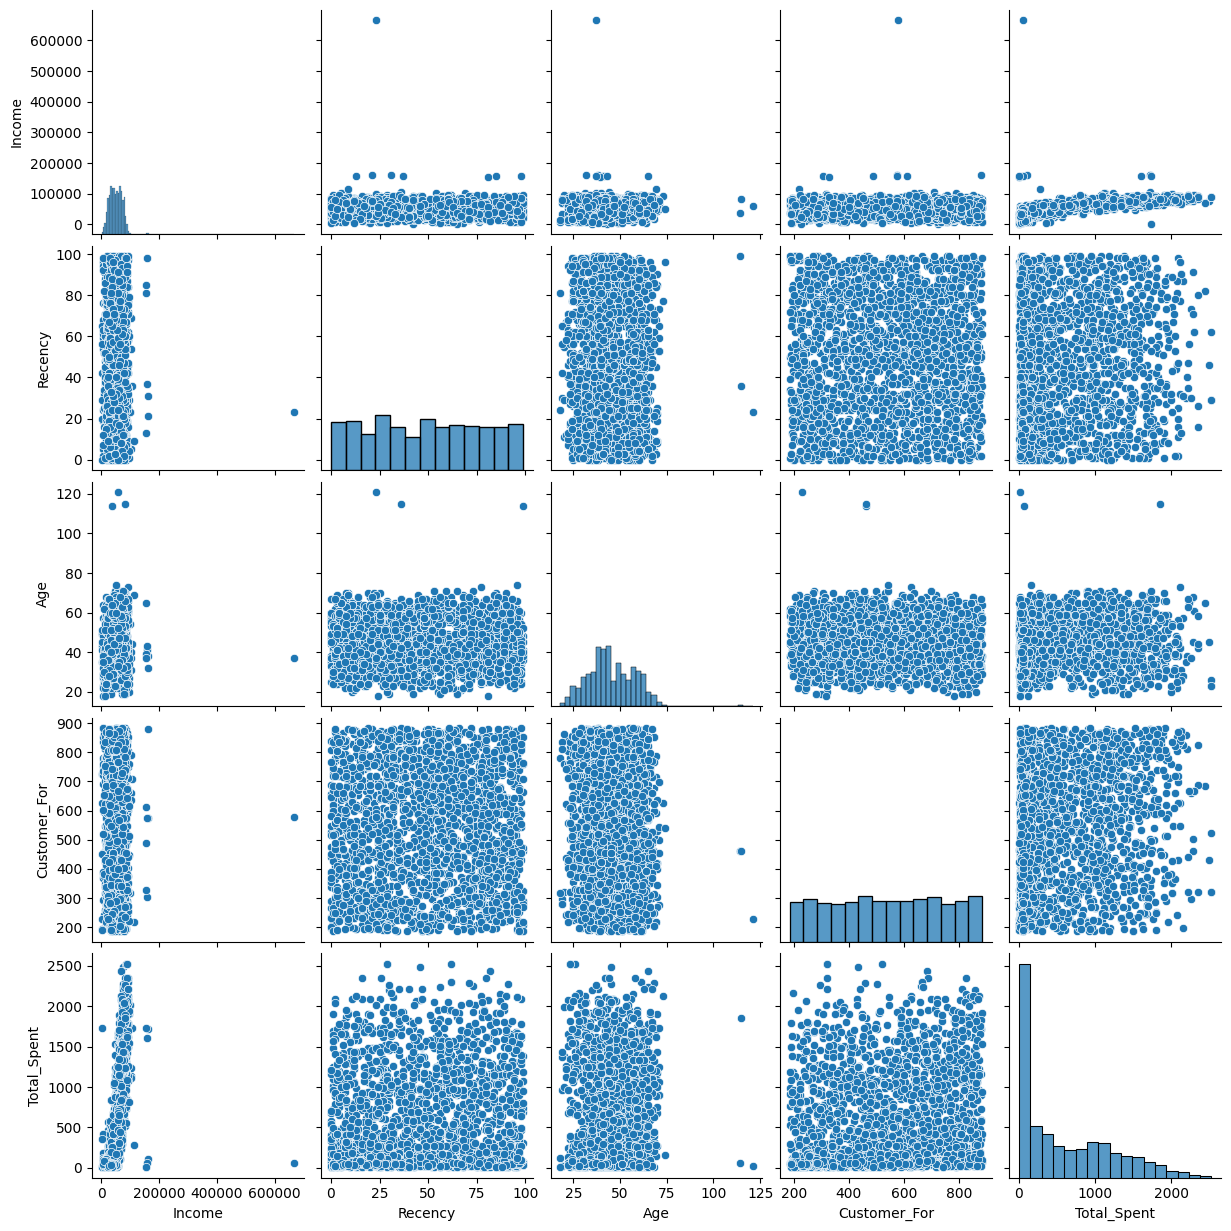

In [10]:
# Select columns to plot
selected_columns = campaign_data[["Income", "Recency", "Age", "Customer_For", "Total_Spent"]]

# Create a pairplot using Seaborn with a visually appealing color palette
sns.pairplot(selected_columns)

# Display the plot using matplotlib.pyplot
plt.show()

In [11]:
# Dropping the outliers by setting a cap on Age and income.
campaign_data = campaign_data[(campaign_data["Age"] < 100)]
campaign_data = campaign_data[(campaign_data["Income"] < 200000)]
print("The total number of data-points after removing the outliers are:", len(campaign_data))

The total number of data-points after removing the outliers are: 2212


In [12]:
numeric_campaign_data = campaign_data.select_dtypes(include=np.number)
numeric_campaign_data = campaign_data.select_dtypes(include=np.number)
to_drop1 = ['Promo1', 'Promo2', 'Promo3', 'Promo4', 'Promo5', 'Promo6', 'Wine', 'Fruits', 'Meat', 'Fish', 'Sweets',
            'Gold', 'Web', 'Catalog', 'Store']
numeric_campaign_data = numeric_campaign_data.drop(to_drop1, axis=1)


In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = numeric_campaign_data.drop('Offers_Accepted', axis=1)
y = numeric_campaign_data['Offers_Accepted']

num_top_features = 5
selector = SelectKBest(mutual_info_classif, k=num_top_features)
selector.fit(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Top {num_top_features} features based on mutual information:")
print(selected_features)

Top 5 features based on mutual information:
Index(['Income', 'WebConversionRate', 'Total_Spent', 'Total_Purchases',
       'Is_Parent'],
      dtype='object')


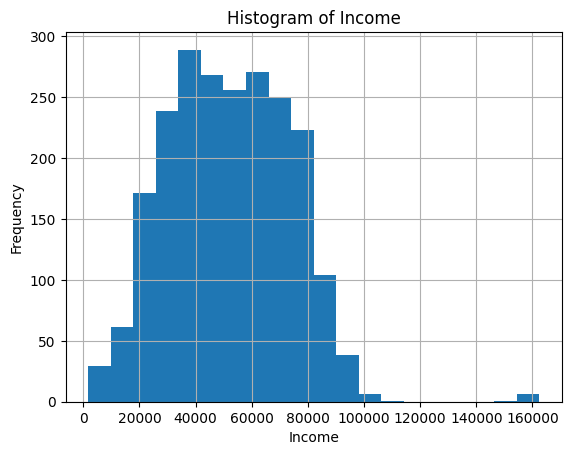

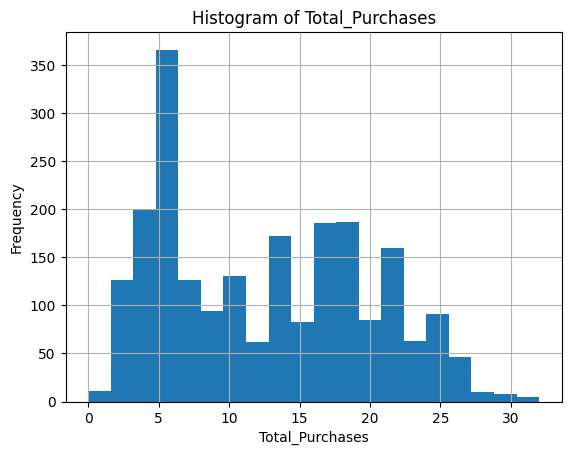

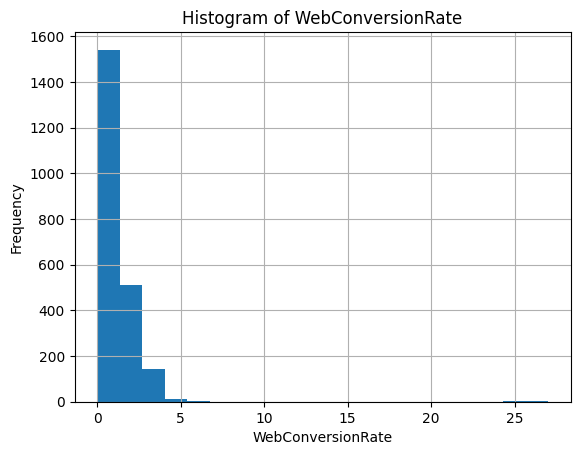

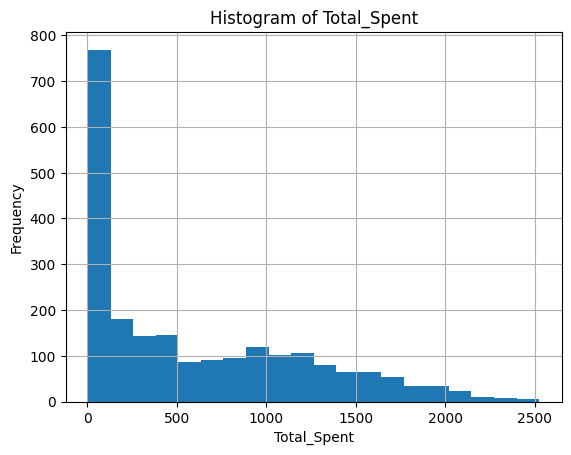

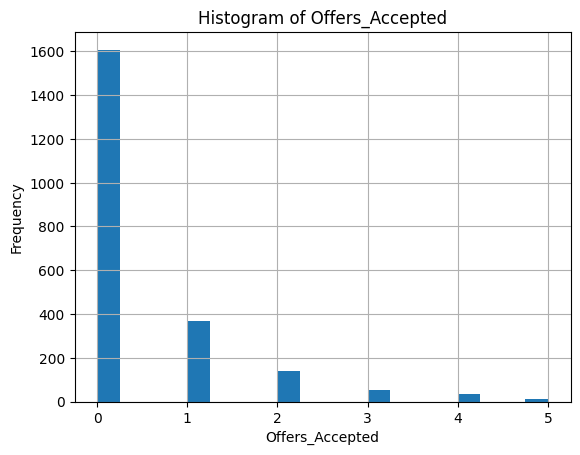

In [14]:
campaign_data_scale = numeric_campaign_data[
    ['Income', 'Total_Purchases', 'WebConversionRate', 'Total_Spent', 'Offers_Accepted']]

for column in campaign_data_scale.columns:
    plt.figure()
    campaign_data_scale[column].hist(bins=20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [15]:
gaussian_features = ['Income']
non_gaussian_features = ['Total_Purchases', 'Total_Spent', 'Offers_Accepted', 'WebConversionRate']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), gaussian_features),
        ('minmax_scaler', MinMaxScaler(), non_gaussian_features)
    ], remainder='passthrough')
campaign_data_scaled = preprocessor.fit_transform(campaign_data_scale)
campaign_data_scaled = pd.DataFrame(campaign_data_scaled, columns=gaussian_features + non_gaussian_features)
campaign_data_scaled.describe()

Income  Total_Purchases  Total_Spent  Offers_Accepted  \
count  2.212000e+03      2212.000000  2212.000000      2212.000000   
mean  -1.252765e-16         0.392716     0.238995         0.089783   
std    1.000226e+00         0.225170     0.239093         0.178603   
min   -2.333791e+00         0.000000     0.000000         0.000000   
25%   -7.771113e-01         0.187500     0.025397         0.000000   
50%   -2.731156e-02         0.375000     0.155556         0.000000   
75%    7.679525e-01         0.570312     0.413889         0.200000   
max    5.131311e+00         1.000000     1.000000         1.000000   

       WebConversionRate  
count        2212.000000  
mean            0.039896  
std             0.044875  
min             0.000000  
25%             0.012346  
50%             0.027778  
75%             0.055556  
max             1.000000

Elbow Method to determine the number of clusters to be formed:


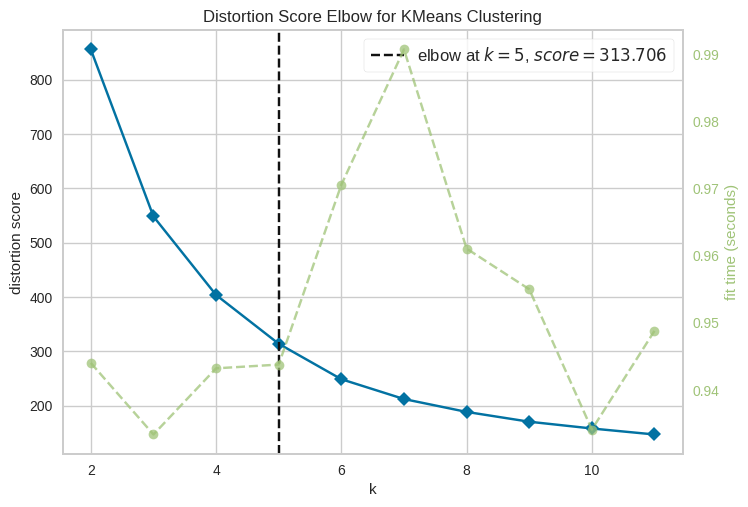

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
from yellowbrick.cluster import KElbowVisualizer

# Quick examination of elbow method to find the number of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=11)
Elbow_M.fit(campaign_data_scaled)
Elbow_M.show()

In [18]:
# Number of clusters
num_clusters = 5

# Set a seed for reproducibility
random_seed = 18

# Initialize the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed)

# Fit the model to the data
kmeans.fit(campaign_data_scaled)

# Get the cluster assignments for each data point
clusters = kmeans.predict(campaign_data_scaled)

# Add the cluster assignments as a new column in the original dataframe
campaign_data["cluster"] = clusters

# Save dataframe as csv
campaign_data.to_csv('data_clustered.csv', index=False)

In [19]:
# Create a colormap
mycolormap = ["#F57C00", "#1976D2", "#E53935", "#43A047", "#8E24AA"]

# Create a custom color sequence for the clusters
color_sequence = px.colors.qualitative.Plotly[:len(campaign_data['cluster'].unique())]
colormap = mycolormap

In [20]:
fig = px.scatter_3d(campaign_data, x='Income', y='Customer_For', z='Total_Spent',
                    color='cluster', color_discrete_map=colormap,
                    opacity=1, height=800, width=800)

fig.update_traces(marker=dict(size=6, line=dict(width=1)), selector=dict(mode='markers'))

fig.update_layout(scene=dict(xaxis_title='Income', xaxis_title_font=dict(color='black'),
                             yaxis_title='Customer_For', yaxis_title_font=dict(color='black'),
                             zaxis_title='Total_Spent', zaxis_title_font=dict(color='black')),
                  title='The Plot of the Clusters',
                  font=dict(family="Gilroy", color='black', size=12))

fig.show()

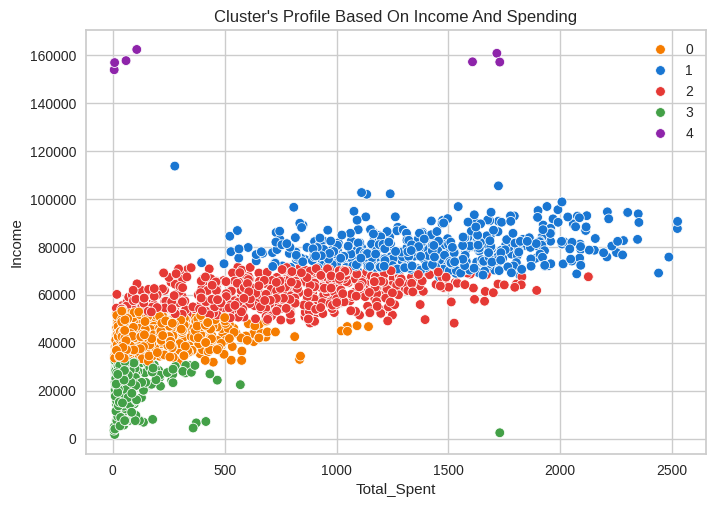

In [21]:
pl = sns.scatterplot(data=campaign_data, x=campaign_data["Total_Spent"], y=campaign_data["Income"],
                     hue=campaign_data["cluster"], palette=mycolormap)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

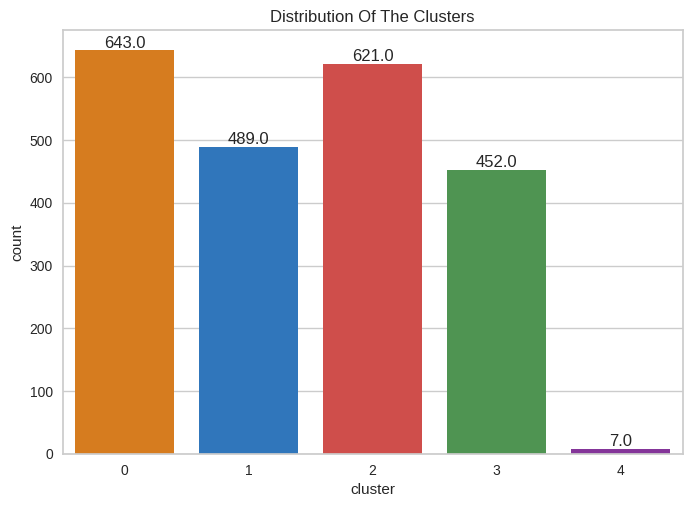

In [22]:
pal = mycolormap
pl = sns.countplot(x=campaign_data["cluster"], palette=pal)
pl.set_title("Distribution Of The Clusters")
# Add value labels to the bars
for i in pl.patches:
    pl.annotate(i.get_height(), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='bottom', fontsize=12)
plt.show()

In [23]:
# Drop cluster number 4
campaign_data.drop(campaign_data[campaign_data["cluster"] == 4].index, inplace=True)
# Update the palette
mycolormap = ["#F57C00", "#1976D2", "#E53935", "#43A047"]

# Aggregate the data by cluster and sum the Offers_Accepted column
agg_data = campaign_data.groupby('cluster')['Offers_Accepted'].sum().reset_index()

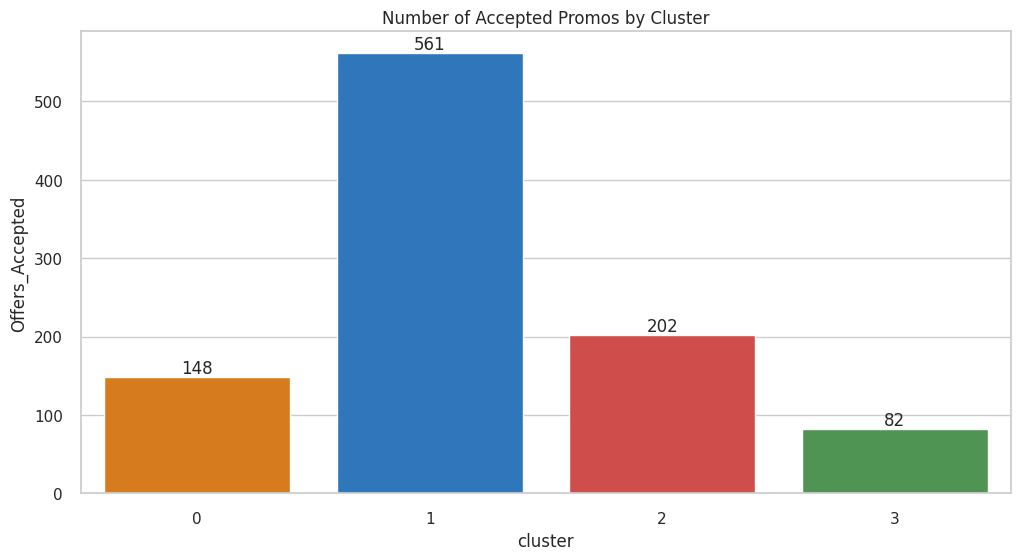

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Offers_Accepted", data=agg_data, palette=mycolormap)
ax.set_title("Number of Accepted Promos by Cluster")

# Add labels to the bars
for i, row in agg_data.iterrows():
    ax.annotate(f"{row['Offers_Accepted']}", (i, row['Offers_Accepted']), ha='center', va='bottom', fontsize=12)

plt.show()

In [25]:
# Calculate the total number of accepted offers for all clusters
total_accepted_offers = agg_data['Offers_Accepted'].sum()

# Calculate the percentage of offers accepted by each cluster
agg_data['Acceptance_Percentage'] = (agg_data['Offers_Accepted'] / total_accepted_offers) * 100

# Display the results
print("Percentage of Accepted Offers by Cluster:")
for index, row in agg_data.iterrows():
    print(f"Cluster {row['cluster']}: {row['Acceptance_Percentage']:.2f}%")

Percentage of Accepted Offers by Cluster:
Cluster 0.0: 14.90%
Cluster 1.0: 56.50%
Cluster 2.0: 20.34%
Cluster 3.0: 8.26%


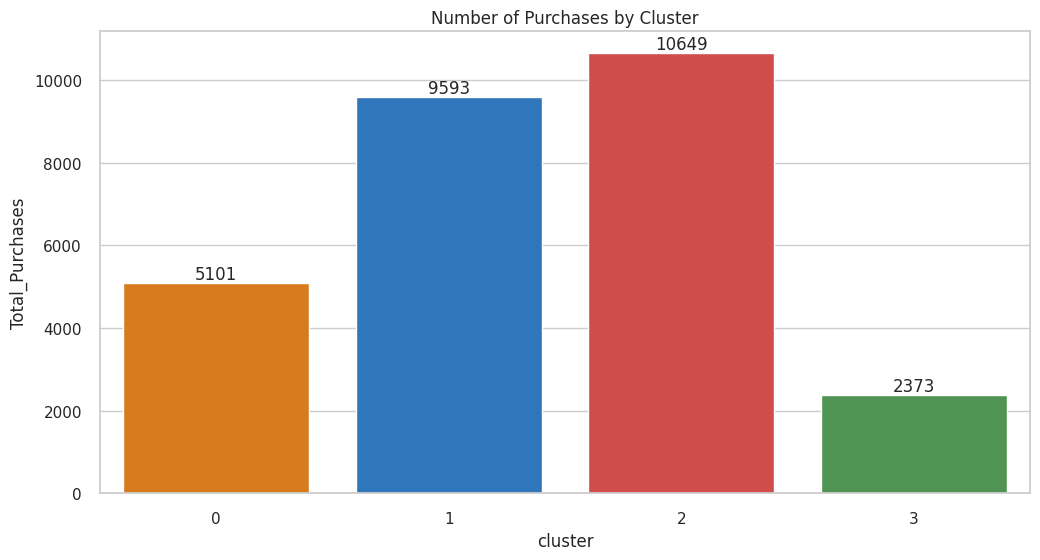

In [26]:
# Aggregate the data by cluster and sum the Offers_Accepted column
agg_data = campaign_data.groupby('cluster')['Total_Purchases'].sum().reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Total_Purchases", data=agg_data, palette=mycolormap)
ax.set_title("Number of Purchases by Cluster")

# Add labels to the bars
for i, row in agg_data.iterrows():
    ax.annotate(f"{row['Total_Purchases']}", (i, row['Total_Purchases']), ha='center', va='bottom', fontsize=12)

plt.show()

In [27]:
# Aggregate the data by cluster and sum the Offers_Accepted and Total_Purchases columns
agg_data = campaign_data.groupby('cluster')[['Offers_Accepted', 'Total_Purchases']].sum().reset_index()

# Calculate the percentage of purchases made by offers for each cluster
agg_data['Percentage_Offers_Accepted'] = (agg_data['Offers_Accepted'] / agg_data['Total_Purchases']) * 100

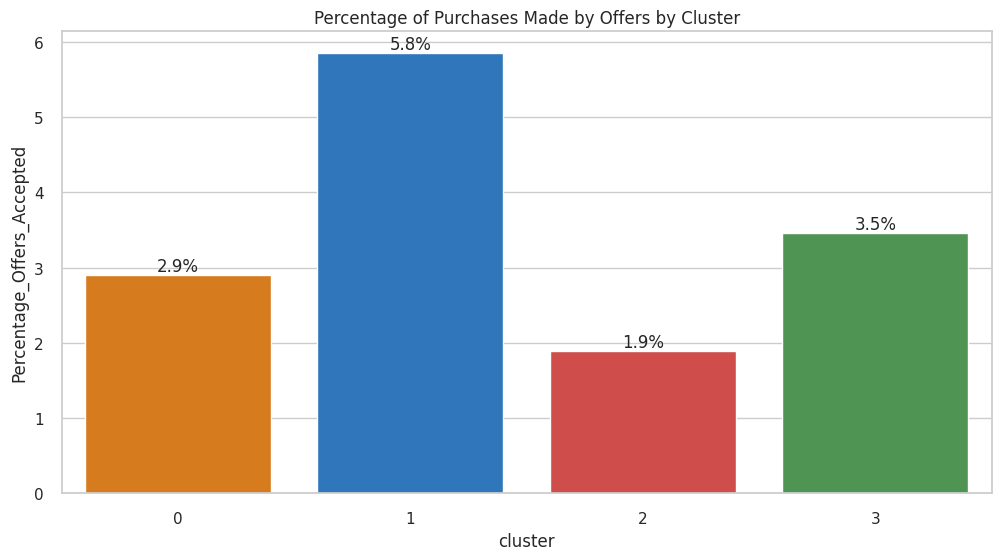

In [28]:
# Create the barplot with percentage of purchases made by offers for each cluster
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Percentage_Offers_Accepted", data=agg_data, palette=mycolormap)
ax.set_title("Percentage of Purchases Made by Offers by Cluster")

for i, row in agg_data.iterrows():
    label = "{:.1f}%".format(row['Percentage_Offers_Accepted'])  # format label as percentage with 1 decimal place
    ax.annotate(label, (i, row['Percentage_Offers_Accepted']), ha='center', va='bottom', fontsize=12)

plt.show()

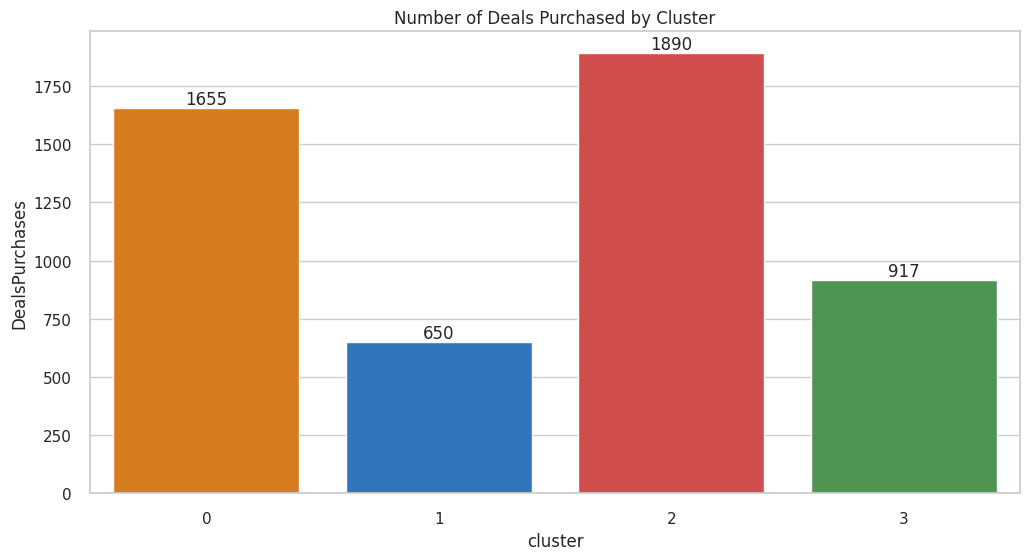

In [29]:
# Aggregate the data by cluster and sum the Deals Purchases column
agg_data = campaign_data.groupby('cluster')['DealsPurchases'].sum().reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="DealsPurchases", data=agg_data, palette=mycolormap)
ax.set_title("Number of Deals Purchased by Cluster")

# Add labels to the bars
for i, row in agg_data.iterrows():
    ax.annotate(f"{row['DealsPurchases']}", (i, row['DealsPurchases']), ha='center', va='bottom', fontsize=12)

plt.show()

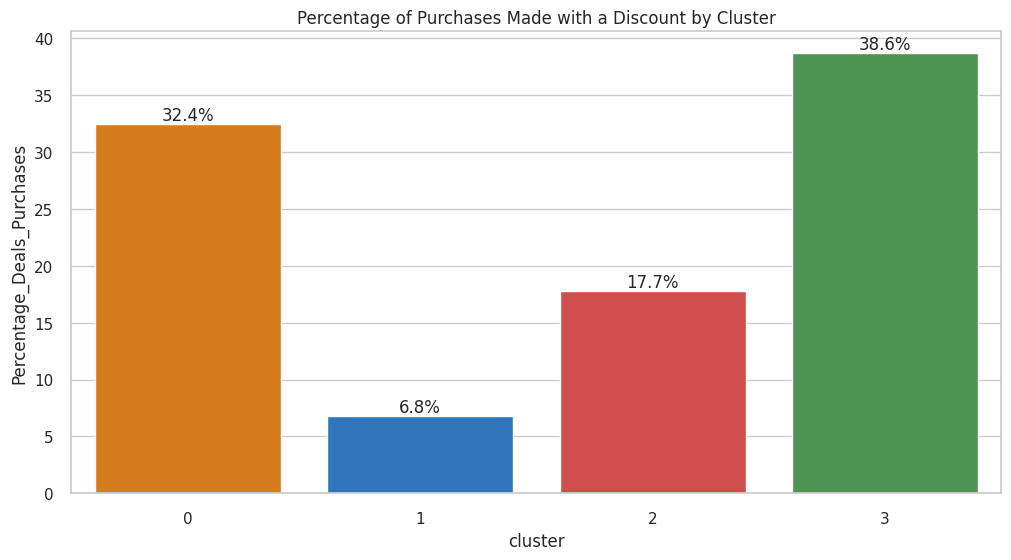

In [30]:
# Aggregate the data by cluster and sum the NumDealsPurchases and Total_Purchases columns
agg_data = campaign_data.groupby('cluster')[['DealsPurchases', 'Total_Purchases']].sum().reset_index()

# Calculate the percentage of purchases made with a discount for each cluster
agg_data['Percentage_Deals_Purchases'] = (agg_data['DealsPurchases'] / agg_data['Total_Purchases']) * 100

# Create the barplot with percentage of purchases made with a discount for each cluster
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Percentage_Deals_Purchases", data=agg_data, palette=mycolormap)
ax.set_title("Percentage of Purchases Made with a Discount by Cluster")

for i, row in agg_data.iterrows():
    label = "{:.1f}%".format(row['Percentage_Deals_Purchases'])  # format label as percentage with 1 decimal place
    ax.annotate(label, (i, row['Percentage_Deals_Purchases']), ha='center', va='bottom', fontsize=12)

plt.show()

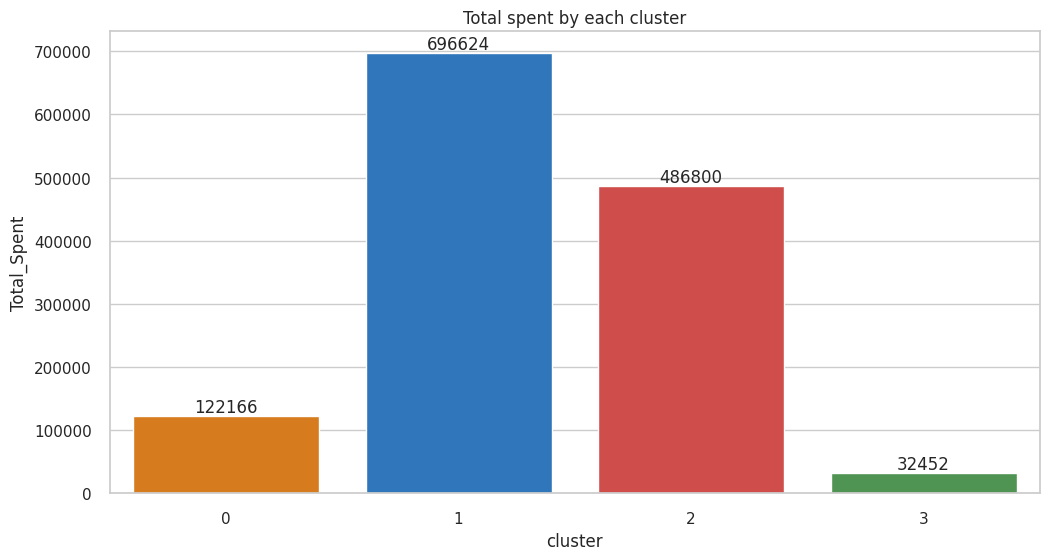

In [31]:
# Aggregate the data by cluster and get total spent by each cluster
agg_data = campaign_data.groupby('cluster')['Total_Spent'].sum().reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Total_Spent", data=agg_data, palette=mycolormap)
ax.set_title("Total spent by each cluster")

# Add labels to the bars
for i, row in agg_data.iterrows():
    ax.annotate(f"{row['Total_Spent']}", (i, row['Total_Spent']), ha='center', va='bottom', fontsize=12)

plt.show()

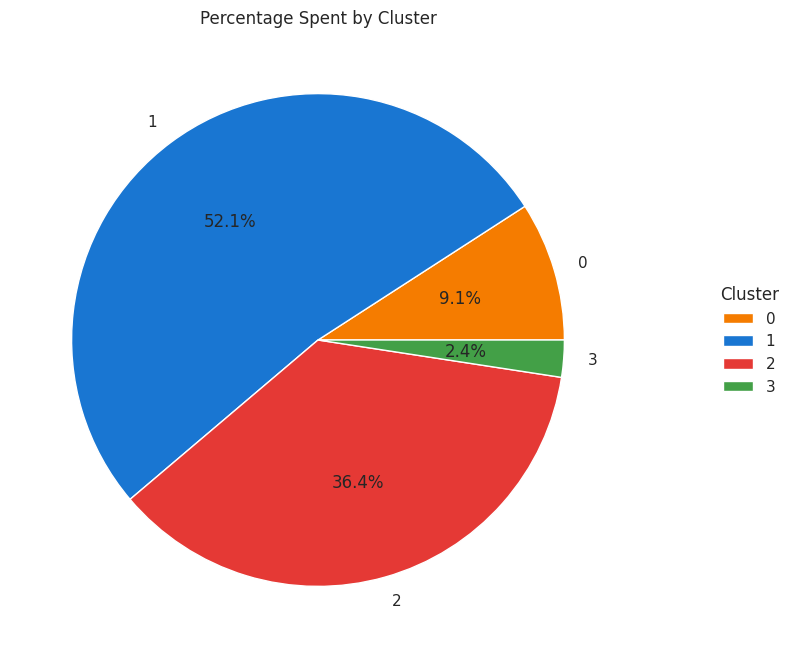

In [32]:
# Aggregate the data by cluster and get the total spent by each cluster
agg_data = campaign_data.groupby('cluster')['Total_Spent'].sum().reset_index()

# Calculate the percentage spent for each cluster
agg_data['Percentage_Spent'] = agg_data['Total_Spent'] / agg_data['Total_Spent'].sum() * 100

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(agg_data['Percentage_Spent'], labels=agg_data['cluster'], autopct='%1.1f%%', colors=mycolormap)
plt.title('Percentage Spent by Cluster')

# Create legend
plt.legend(agg_data['cluster'], title='Cluster', loc='center', bbox_to_anchor=(1.2, 0.5))

plt.show()

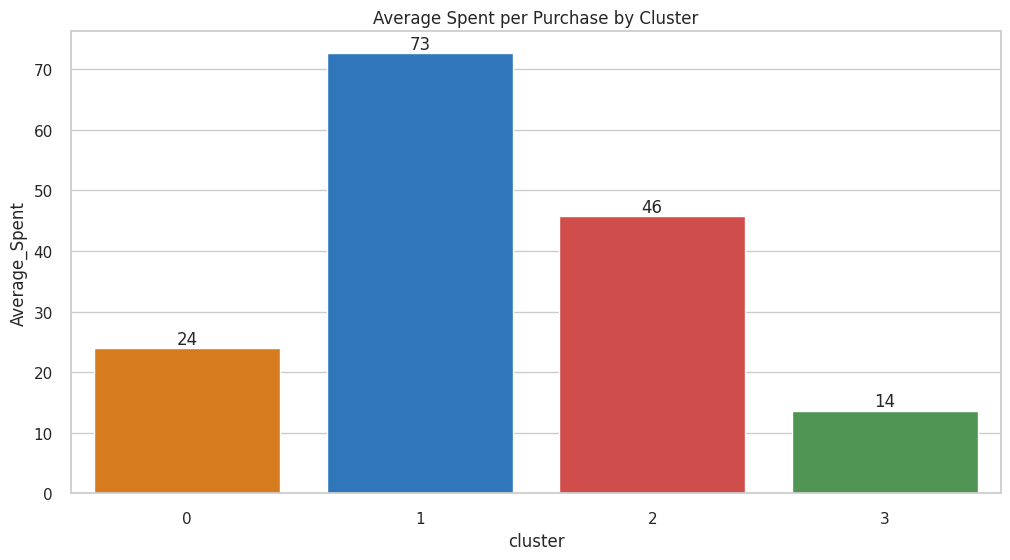

In [33]:
# Aggregate the data by cluster and get average spent per purchase by cluster
agg_data = campaign_data.groupby('cluster')[['Total_Spent', 'Total_Purchases']].sum().reset_index()

# Calculate the average Spent per purchase for each cluster
agg_data['Average_Spent'] = agg_data['Total_Spent'] / agg_data['Total_Purchases']

# Create the barplot with average Spent per purchase for each cluster
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Average_Spent", data=agg_data, palette=mycolormap)
ax.set_title("Average Spent per Purchase by Cluster")

for i, row in agg_data.iterrows():
    label = "{:.0f}".format(row['Average_Spent'])  # format label as percentage with 1 decimal place
    ax.annotate(label, (i, row['Average_Spent']), ha='center', va='bottom', fontsize=12)

plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

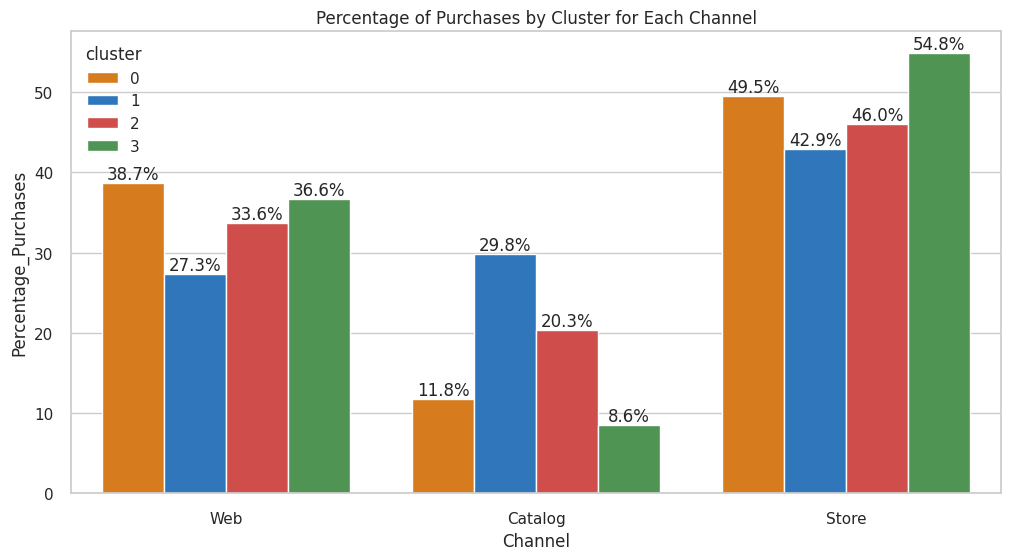

In [34]:
# Channels
channel = ['Web', 'Catalog', 'Store']
 
# Aggregate the acceptance data by cluster
agg_data = campaign_data.groupby('cluster')[channel].sum().reset_index()
 
# Calculate the percentage of purchases coming from each channel for each cluster
agg_data[channel] = agg_data[channel].div(agg_data[channel].sum(axis=1), axis=0) * 100
 
# Melt the aggregated data to make it suitable for plotting with seaborn
melted_data = pd.melt(agg_data, id_vars='cluster', value_vars=channel,
                      var_name='Channel', value_name='Percentage_Purchases')
 
# Create the barplot with cluster hue
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Channel", y="Percentage_Purchases", hue="cluster", data=melted_data, palette=mycolormap)
ax.set_title("Percentage of Purchases by Cluster for Each Channel")
 
# Add value labels to the bars
for i, p in enumerate(ax.patches):
    value = agg_data.iloc[int(i/3), int(i%3)+1].round(1).astype(str) + '%'
    ax.annotate(value, (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=12)

plt.show()

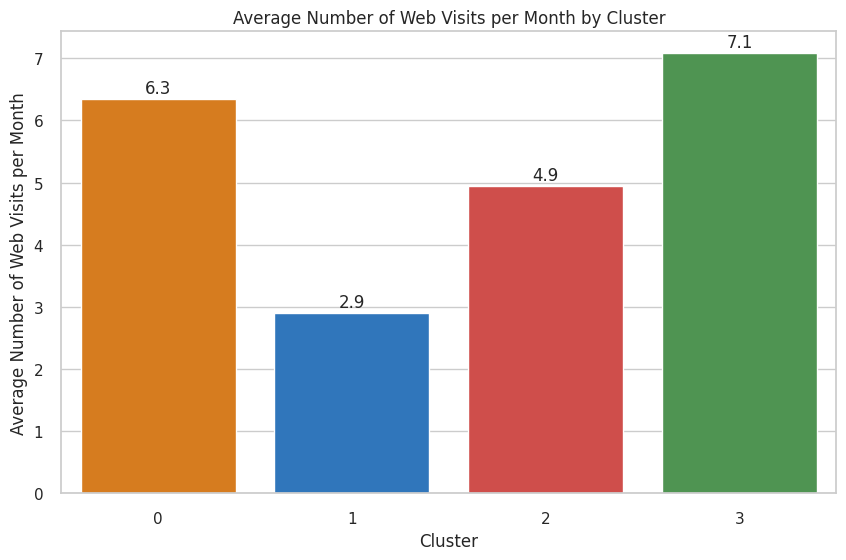

In [35]:
# Calculate the average number of web visits per month for each cluster
avg_num_visits_per_month = campaign_data.groupby('cluster')['WebVisits'].mean()
 
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_num_visits_per_month.index, y=avg_num_visits_per_month, palette=mycolormap)
plt.title("Average Number of Web Visits per Month by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Number of Web Visits per Month")
# Annotate the bars with their values
for i, v in enumerate(avg_num_visits_per_month):
    plt.text(i, v+0.1, str(round(v, 1)), ha='center', fontsize=12)
 
plt.show()

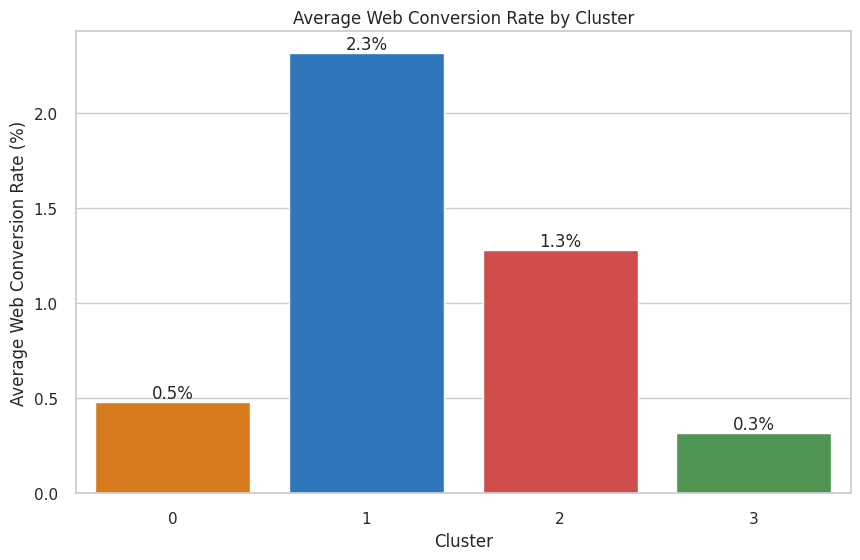

In [36]:
# Calculate the average WebConversionRate for each cluster
web_conversion_rate = campaign_data.groupby('cluster')['WebConversionRate'].mean()
 
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=web_conversion_rate.index, y=web_conversion_rate, palette=mycolormap)
plt.title("Average Web Conversion Rate by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Web Conversion Rate (%)")
 
# Annotate the bars with their values and percentage symbols
for i, v in enumerate(web_conversion_rate):
    plt.text(i, v+0, str(round(v, 1)) + '%', ha='center', va='bottom', fontsize=12)
 
plt.show()

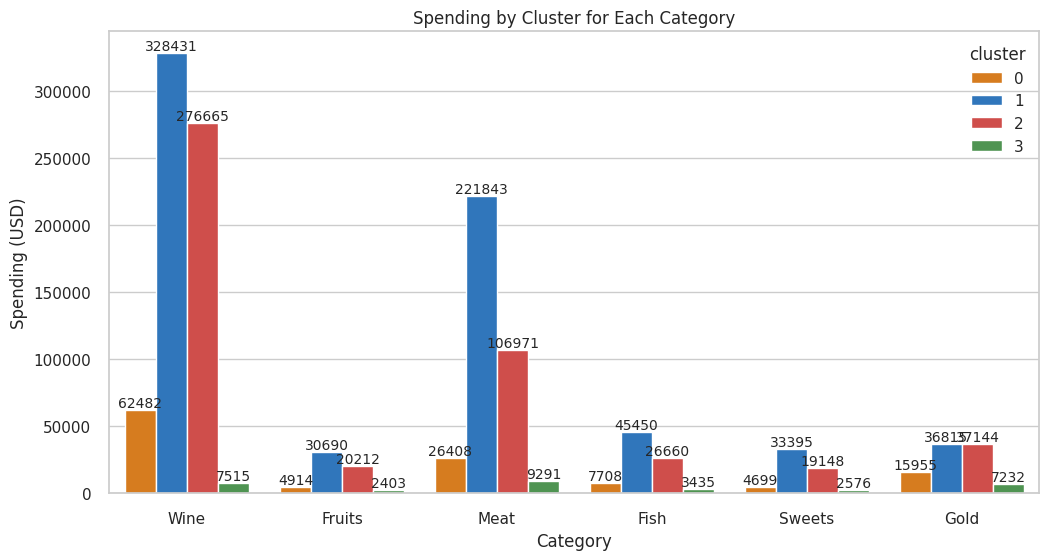

In [37]:
# List of product categories
categories = ['Wine', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
 
# Aggregate the Spending data by cluster
agg_data = campaign_data.groupby('cluster')[categories].sum().reset_index()
 
# Melt the aggregated data to make it suitable for plotting with seaborn
melted_data = pd.melt(agg_data, id_vars='cluster', value_vars=categories,
                      var_name='Category', value_name='Spending')
 
# Create the barplot with cluster hue
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Category", y="Spending", hue="cluster", data=melted_data, palette=mycolormap)
ax.set_title("Spending by Cluster for Each Category")
ax.set_ylabel("Spending (USD)")
 
# Add the Spending values as text labels on each bar
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10)
 
plt.show()

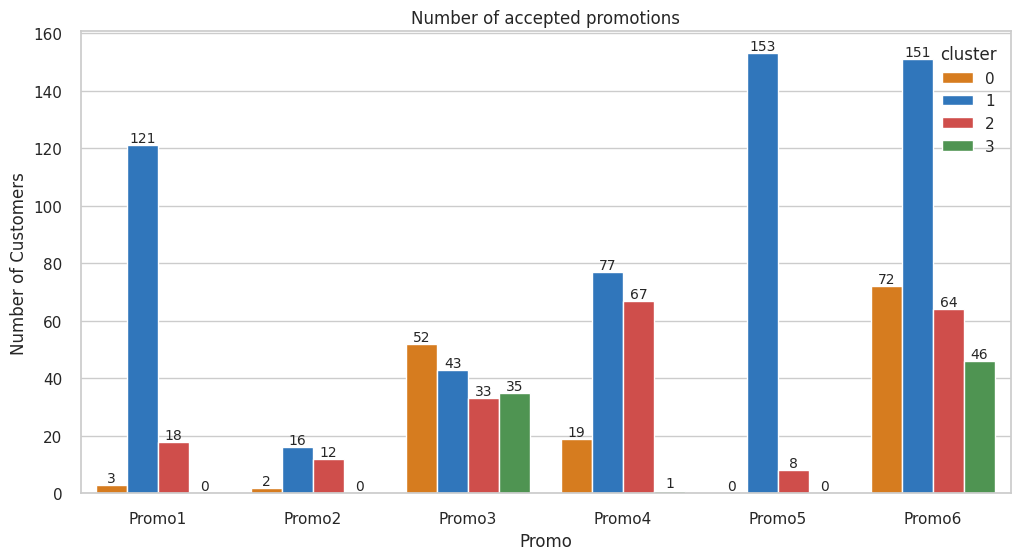

In [38]:
# List of promo campaigns
promos = ['Promo1', 'Promo2', 'Promo3', 'Promo4', 'Promo5', 'Promo6']
 
# Aggregate the acceptance data by cluster
agg_data = campaign_data.groupby('cluster')[promos].sum().reset_index()
 
# Melt the aggregated data to make it suitable for plotting with seaborn
melted_data = pd.melt(agg_data, id_vars='cluster', value_vars=promos,
                      var_name='Promo', value_name='Num_Customers')
 
# Create the barplot with cluster hue
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Promo", y="Num_Customers", hue="cluster", data=melted_data, palette=mycolormap)
ax.set_title("Number of accepted promotions")
ax.set_ylabel("Number of Customers")
 
# Add the number of accepted promos as text labels on each bar
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10)
 
plt.show()

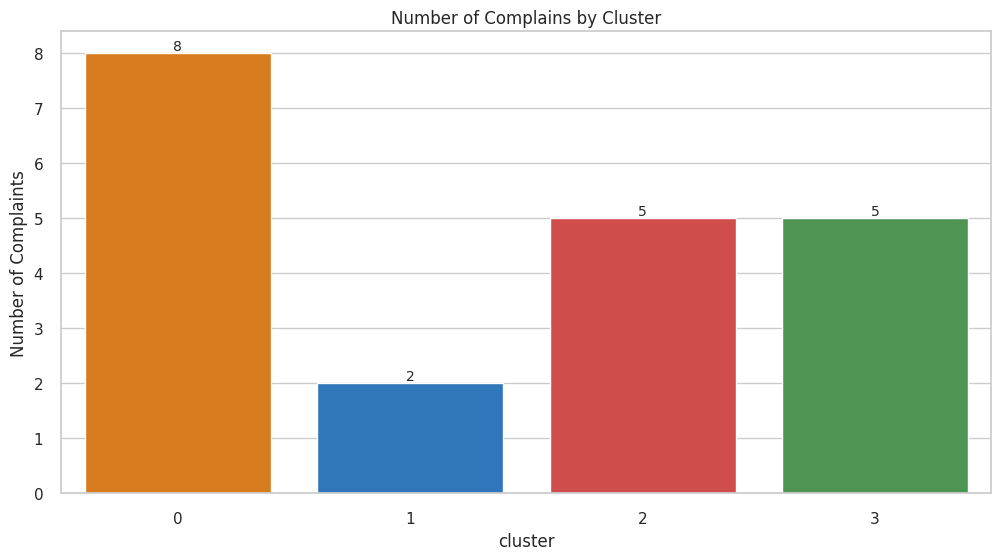

In [39]:
# Aggregate the data by cluster and sum the Complain column
agg_data = campaign_data.groupby('cluster')['Complain'].sum().reset_index()
 
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="cluster", y="Complain", data=agg_data, palette=mycolormap)
ax.set_title("Number of Complains by Cluster")
ax.set_ylabel("Number of Complaints")
 
# Add the number of complaints as text labels on each bar
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10)
 
plt.show()

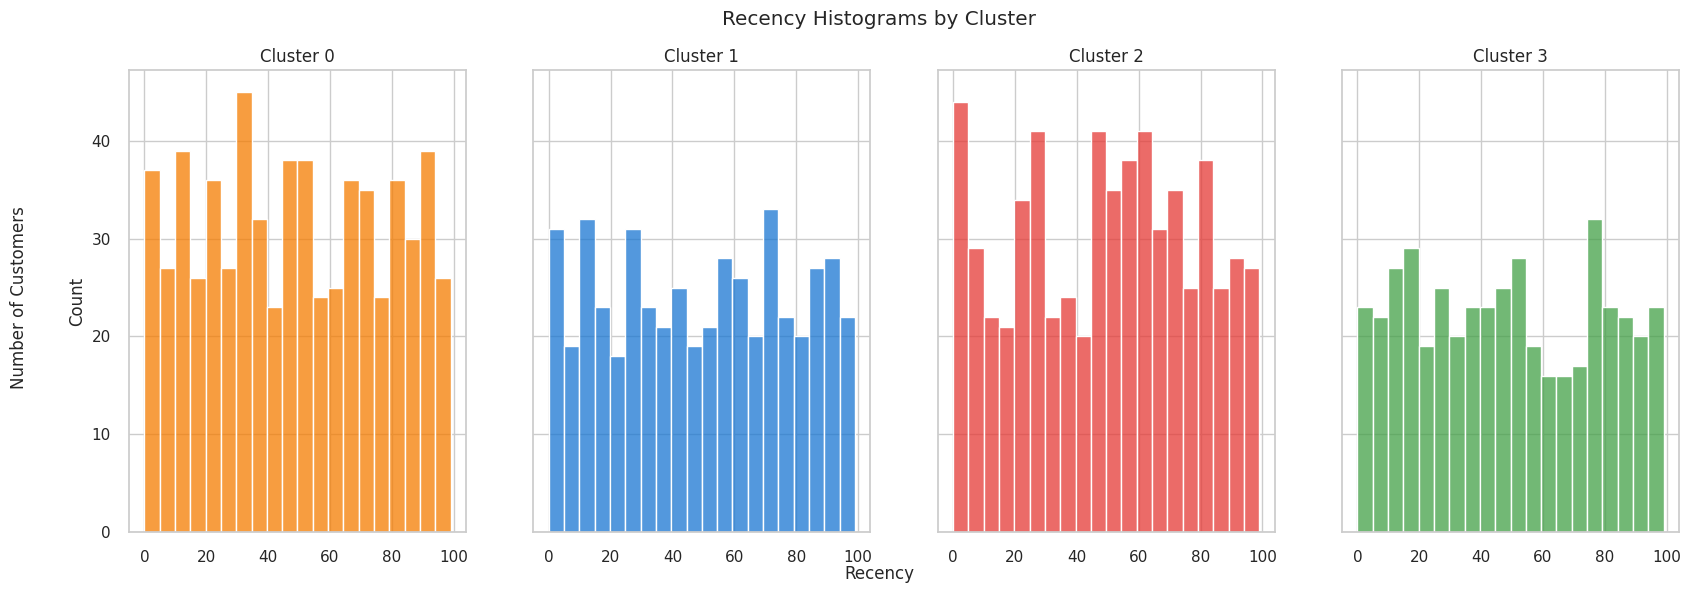

In [40]:
# Set the style
sns.set(style="whitegrid")
 
# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
 
# Set common titles and labels
fig.suptitle("Recency Histograms by Cluster")
fig.text(0.5, 0.04, 'Recency', ha='center', va='center')
fig.text(0.07, 0.5, 'Number of Customers', ha='center', va='center', rotation='vertical')
 
# Define the cluster list
clusters = [0, 1, 2, 3]
 
# Plot the Recency histograms for each cluster
for i, cluster in enumerate(clusters):
    cluster_data = campaign_data[campaign_data['cluster'] == cluster]
    sns.histplot(data=cluster_data, x='Recency', bins=20, color=mycolormap[cluster], ax=axes[i], kde=False)
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_xlabel("")
 
# Display the plots
plt.show()

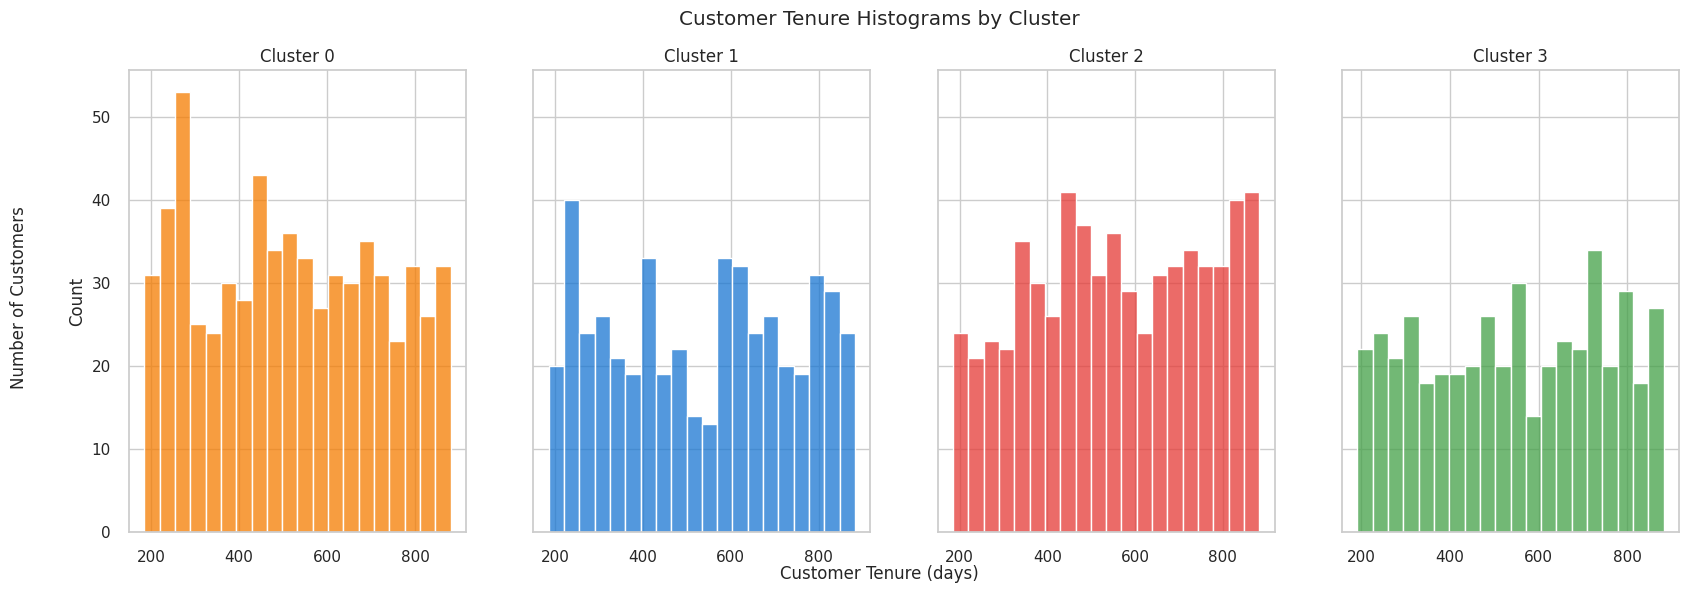

In [41]:
# Set the style
sns.set(style="whitegrid")
 
# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
 
# Set common titles and labels
fig.suptitle("Customer Tenure Histograms by Cluster")
fig.text(0.5, 0.04, 'Customer Tenure (days)', ha='center', va='center')
fig.text(0.07, 0.5, 'Number of Customers', ha='center', va='center', rotation='vertical')
 
# Define the cluster list
clusters = [0, 1, 2, 3]
 
# Plot the Customer Tenure histograms for each cluster
for i, cluster in enumerate(clusters):
    cluster_data = campaign_data[campaign_data['cluster'] == cluster]
    sns.histplot(data=cluster_data, x='Customer_For', bins=20, color=mycolormap[cluster], ax=axes[i], kde=False)
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_xlabel("")
 
# Display the plots
plt.show()

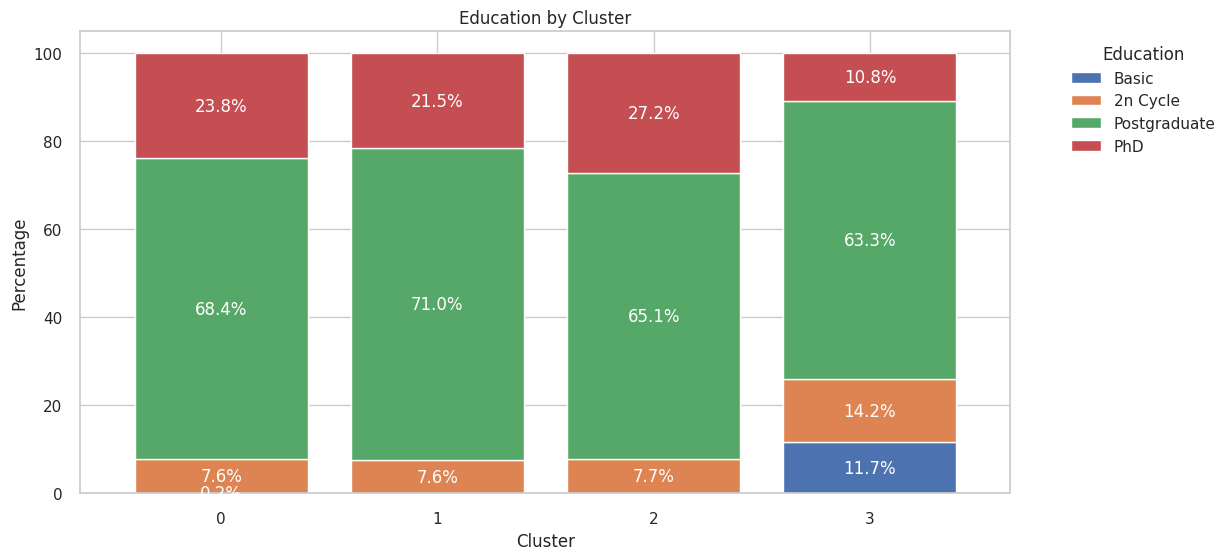

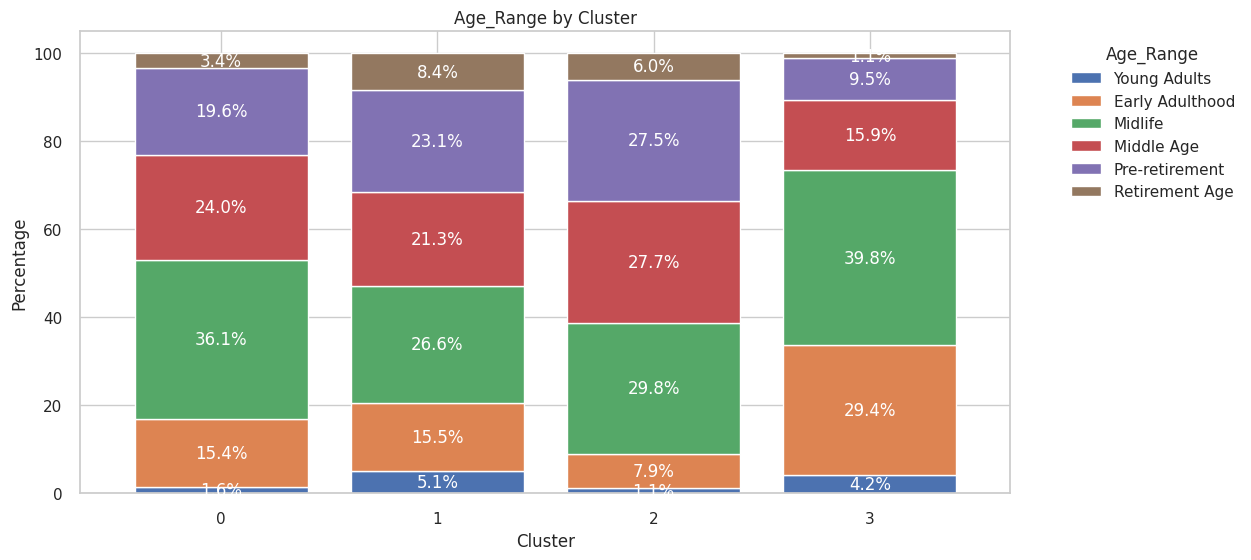

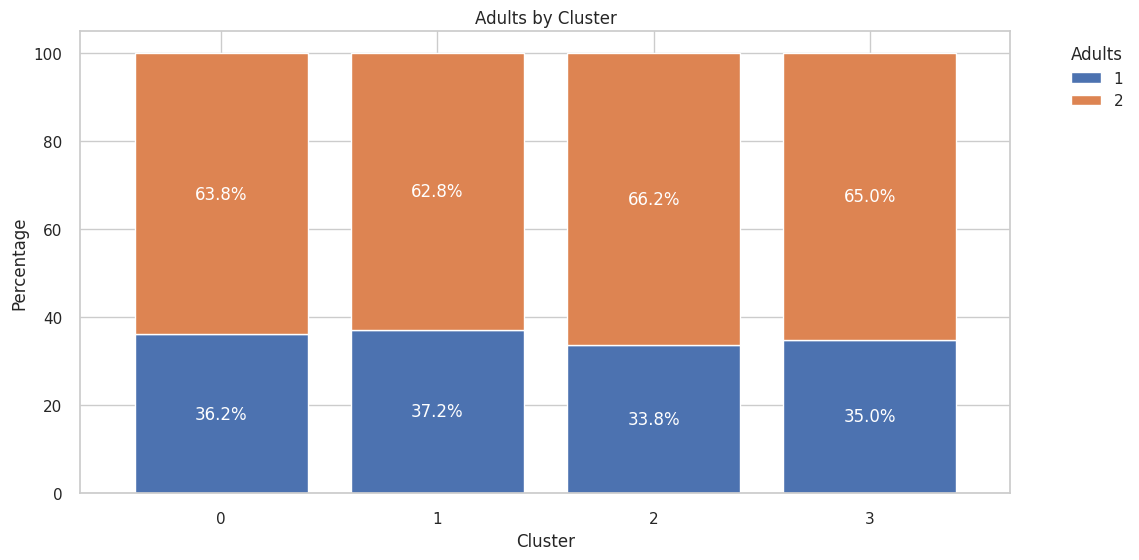

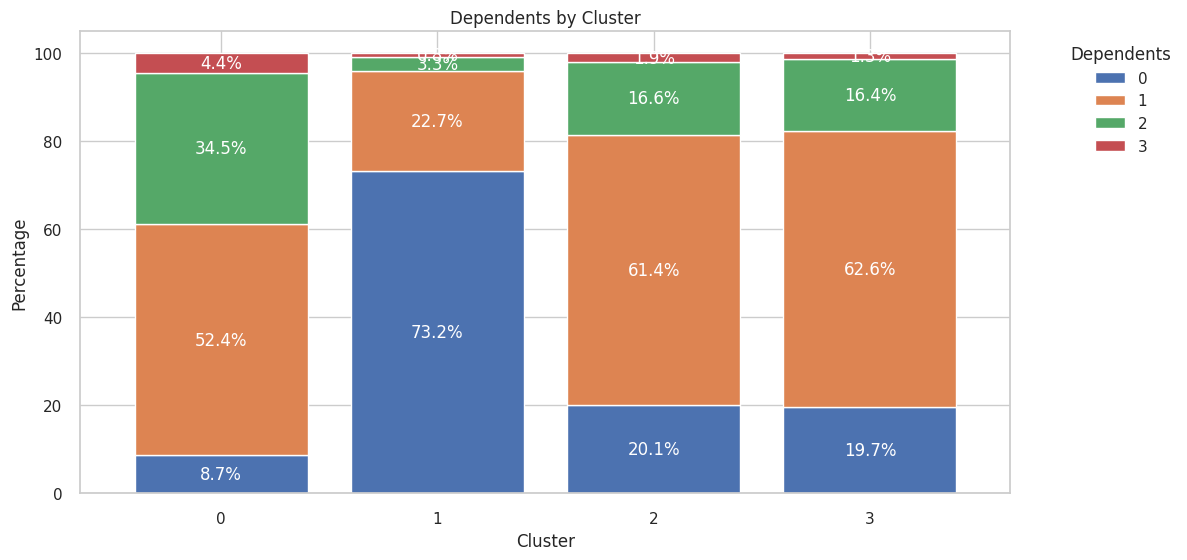

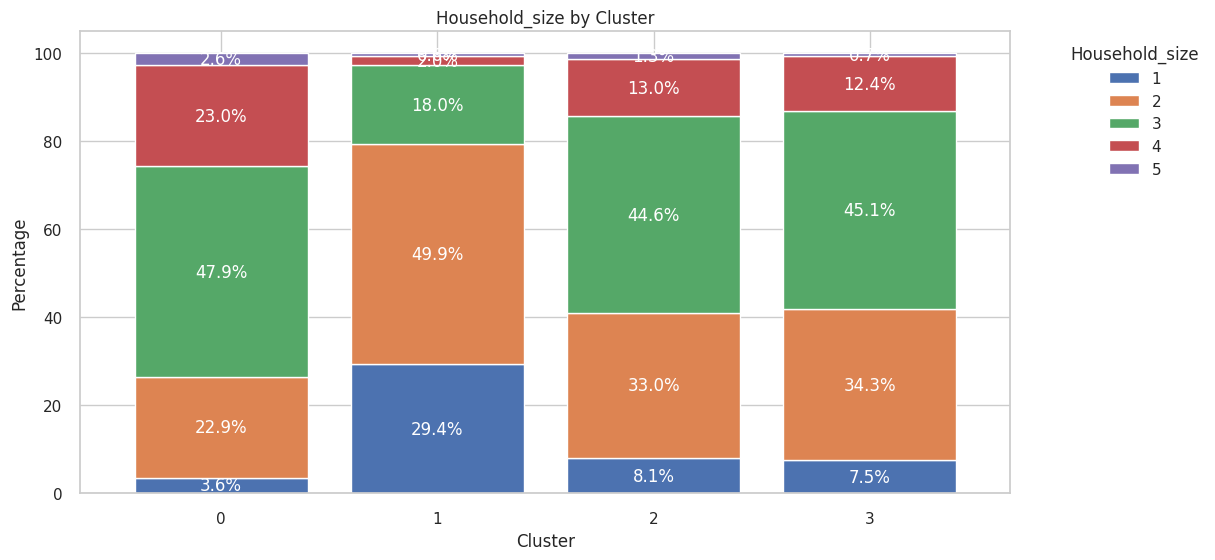

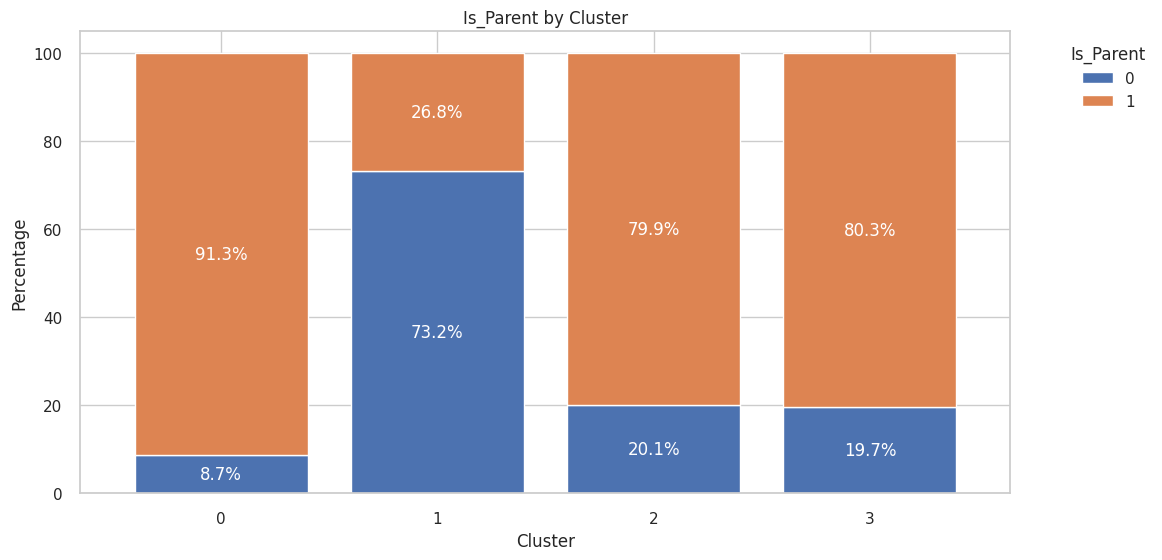

In [42]:
#Create list of features for what to create visualizations 
personal_variables = ['Education', 'Age_Range', 'Adults', 'Dependents', 'Household_size', 'Is_Parent']
 
#Create an order for age groups
age_order = ['Young Adults', 'Early Adulthood', 'Midlife', 'Middle Age', 'Pre-retirement', 'Retirement Age']
 
for var in personal_variables:
    # Aggregate the data by cluster and the current variable
    var_agg = campaign_data.groupby(['cluster', var]).size().reset_index(name='count')
    
    if var == 'Education':
        # Sort the education levels in the desired order
        education_order = ['Basic', '2n Cycle', 'Postgraduate', 'PhD']
        var_agg[var] = pd.Categorical(var_agg[var], categories=education_order, ordered=True)
        var_agg = var_agg.sort_values(var)
    elif var == 'Age_Range':
        # Sort the age ranges in the desired order
        var_agg[var] = pd.Categorical(var_agg[var], categories=age_order, ordered=True)
        var_agg = var_agg.sort_values(var)
        
    # Calculate the total count of customers per cluster
    cluster_totals = var_agg.groupby('cluster')['count'].sum()
 
    # Calculate the percentage of each category for each cluster
    var_agg['percentage'] = var_agg.apply(lambda row: row['count'] / cluster_totals[row['cluster']] * 100, axis=1)
 
    # Pivot the aggregated data to create a matrix suitable for stacked bar chart
    var_pivot = var_agg.pivot_table(index='cluster', columns=var, values='percentage', fill_value=0)
 
    # Plot the stacked bar chart
    ax = var_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='white', width=0.8)
    plt.title(f"{var} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Percentage")
    plt.xticks(rotation=0)
    plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
 
    # Add annotations to the chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', color='white', fontsize=12)
 
    plt.show()

Title: Optimizing Customer Segmentation for Effective Promo Campaigns

Executive Summary:

Customer data analysis has identified four distinct customer clusters with varying responsiveness to promotional campaigns. The primary goal is to provide the marketing team with insights into these clusters to tailor their promotional efforts effectively. Our ideal target customer is in Cluster 1, which contributes significantly to overall revenue and has the highest acceptance rate of promotional offers. The marketing team should promote wine and meat categories, leverage the catalog and adjust web offers to increase interest for clients in Cluster 1 to visit the website more often. Analyze Promo campaigns 1, 5, and 6 and target with similar campaign clients from cluster 1 or offer more campaigns like 6 to all customers.

Detailed Findings:

1. Targeting the Ideal Customer - Cluster 1:

Cluster 1, which accounts for 56.5% of all accepted offers and 52.1% of total spending, is our ideal target group. Customers in this cluster have higher average incomes and high education levels and are predominantly adults in their midlife without dependents.

Recommendations:

    Focus promotional campaigns on Cluster 1 customers, who are more likely to accept offers and contribute significantly to store revenue.

    Analyze the characteristics of Cluster 1 customers (e.g., demographics, preferred products, and communication channels) to tailor promotional strategies for other customer segments.

2. Leveraging High-spend Categories:

Wine and meat are the highest spending categories for all clusters. Targeting these high-spend categories can increase overall revenue.

Recommendations:

    Prioritize wine and meat promotions for all clusters.

3. Optimizing Marketing Channels:

Catalog purchases are popular among Cluster 1 customers (29.8%), while Cluster 3 and 4 prefer web channel purchases (38.7% and 36.6%). In-store purchases are most common among Cluster 2 customers (54.8%).

Recommendations:

    Increase catalog promotions targeting Cluster 1 customers.

    Enhance the web channel experience and advertisements targeting Cluster 3 and 4 customers.

    Explore in-store deals opportunities for Cluster 2 customers.

4. Improving Website Efficiency:

Cluster 2 and 3 customers visit the website more frequently but have lower conversion rates. This indicates potential barriers to conversion, such as product offerings, pricing, or user experience. Customers from Cluster 1 have a high website conversion rate but the lowest number of monthly visits. That tells that customers from Cluster 1 either can't find relevant offers through the website or are not aware of it enough, or not happy about their experience.   

Recommendations:

    Conduct user experience research and A/B testing for customers in Clusters 2 and 3 to identify potential barriers to conversion.

    Experiment with different website layouts, product recommendations, and personalized promotions to improve conversion rates for these clusters.

    Find out why customers from Cluster 1 only visit the website sparingly. It can be a massive booster to revenue since they have the highest website conversion rate. 

5. Tailoring Promotions Based on Income and Education:

Lower-income customers (Cluster 2) are more sensitive to price and likely to respond to discount offers. In contrast, higher-income customers (Cluster 1) tend to accept promo campaigns on premium products.

Recommendations:

    For lower-income customers (Cluster 2 and potentially Cluster 3), focus on offering more deals and affordable options to incentivize spending.

    For higher-income customers (Cluster 1 and Cluster 0), focus on promo campaigns on premium products.

6. Emulating Successful Promotions:

Promotion #6 was the most efficient, with high customer acceptance rates, especially Cluster 1. Implement similar campaigns to increase overall promotional efficiency.

Recommendations:

    Launch more campaigns similar to Promo #6, targeting all customers.

    Study the features of Promo #1 and #5, which were successful with Cluster 1 customers, and apply those learnings to future campaigns. 
